In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from matplotlib.lines import Line2D

In [2]:
def plot_training_curves_by_hyperparams(results_file="results/model_results_updated.csv", 
                                       group_by='learning_rate', max_epoch=300):
    """ training curves and group by hyper parameters"""
    
    df = pd.read_csv(results_file)
    df_filtered = df[df['epoch'] <= max_epoch]

    unique_vals = sorted(df_filtered[group_by].unique())

    fig, axes = plt.subplots(1, len(unique_vals), figsize=(5*len(unique_vals), 6))
    if len(unique_vals) == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
    
    for i, val in enumerate(unique_vals):
        subset = df_filtered[df_filtered[group_by] == val]
        
        # Plot each model within the group
        for model_name in subset['model_name'].unique():
            model_data = subset[subset['model_name'] == model_name]
            axes[i].plot(model_data['epoch'], model_data['val_auc'], 
                        label=model_name, alpha=0.7, linewidth=1.5)
        
        axes[i].set_title(f'{group_by}={val}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Validation AUC')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [3]:
def hyperparam_heatmap(final_results_file="results/final_results_updated.csv", 
                               x_param='learning_rate', y_param='hidden_dim', 
                               metric='test_auc'):
    
    df = pd.read_csv(final_results_file)

    pivot_tab = df.pivot_table(values=metric,index=y_param,columns=x_param,aggfunc='mean')

    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_tab,annot=True,fmt='.3f',cmap='viridis')
    plt.title(f'{metric.replace("_", " ").title()} by {x_param} and {y_param}')
    plt.tight_layout()
    plt.show()
    
    return pivot_tab

In [4]:
def compare_final_results(final_results_file="results/final_results.csv", 
                         sort_by='test_auc', top_n=10):
    """Compare final test results across all models"""

    df = pd.read_csv(final_results_file)
    df_sorted = df.sort_values(sort_by, ascending=False).head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Test AUC comparison
    axes[0,0].barh(range(len(df_sorted)), df_sorted['test_auc'])
    axes[0,0].set_yticks(range(len(df_sorted)))
    axes[0,0].set_yticklabels(df_sorted['model_name'], fontsize=8)
    axes[0,0].set_xlabel('Test AUC')
    axes[0,0].set_title('Test AUC Comparison')

    # Precision-Recall comparison
    axes[0,1].scatter(df_sorted['test_recall'], df_sorted['test_precision'], 
                     s=100, alpha=0.7)
    for i, name in enumerate(df_sorted['model_name']):
        axes[0,1].annotate(name, (df_sorted['test_recall'].iloc[i], 
                                 df_sorted['test_precision'].iloc[i]), 
                          fontsize=8, rotation=45)
    axes[0,1].set_xlabel('Test Recall')
    axes[0,1].set_ylabel('Test Precision')
    axes[0,1].set_title('Precision vs Recall')
    
    # Hyperparameter distribution
    axes[1,0].scatter(df_sorted['learning_rate'], df_sorted['hidden_dim'], 
                     c=df_sorted['test_auc'], s=100, cmap='viridis')
    axes[1,0].set_xlabel('Learning Rate')
    axes[1,0].set_ylabel('Hidden Dim')
    axes[1,0].set_title('Hyperparams colored by AUC')
    plt.colorbar(axes[1,0].collections[0], ax=axes[1,0])

    # model complaexity vs performance
    if 'total_params' in df_sorted.columns:
        axes[1,1].scatter(df_sorted['total_params'], df_sorted['test_auc'], 
                         s=100, alpha=0.7)
        axes[1,1].set_xlabel('Total Parameters')
        axes[1,1].set_ylabel('Test AUC')
        axes[1,1].set_title('Model Size vs Performance')

    plt.tight_layout()
    plt.show()
    
    return df_sorted[['model_name', 'test_auc', 'test_precision', 'test_recall', 
                     'hidden_dim', 'num_layers', 'learning_rate', 'drop_out']]

In [5]:
def analyse_hyperparameter_trends(results_file="results/model_results.csv"):
    """Analyse trends in hyperparameters and their effects"""
    df = pd.read_csv(results_file)
    
    # Get final epoch for each model
    final_epochs = df.groupby('model_name').agg({
        'epoch': 'max',
        'val_auc': 'last',
        'hidden_dim': 'first',
        'num_layers': 'first', 
        'learning_rate': 'first',
        'drop_out': 'first'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Learning rate effect
    lr_groups = final_epochs.groupby('learning_rate')['val_auc'].agg(['mean', 'std']).reset_index()
    axes[0,0].errorbar(lr_groups['learning_rate'], lr_groups['mean'], 
                      yerr=lr_groups['std'], marker='o')
    axes[0,0].set_xlabel('Learning Rate')
    axes[0,0].set_ylabel('Final Val AUC')
    axes[0,0].set_title('Learning Rate vs Performance')
    axes[0,0].set_xscale('log')
    
    # Hidden dim effect
    hidden_groups = final_epochs.groupby('hidden_dim')['val_auc'].agg(['mean', 'std']).reset_index()
    axes[0,1].errorbar(hidden_groups['hidden_dim'], hidden_groups['mean'], 
                      yerr=hidden_groups['std'], marker='o')
    axes[0,1].set_xlabel('Hidden Dimension')
    axes[0,1].set_ylabel('Final Val AUC')
    axes[0,1].set_title('Hidden Dimension vs Performance')
    
    # Dropout effect (if available)
    if 'drop_out' in final_epochs.columns and final_epochs['drop_out'].notna().any():
        dropout_groups = final_epochs.groupby('drop_out')['val_auc'].agg(['mean', 'std']).reset_index()
        axes[1,0].errorbar(dropout_groups['drop_out'], dropout_groups['mean'], 
                          yerr=dropout_groups['std'], marker='o')
        axes[1,0].set_xlabel('Dropout Rate')
        axes[1,0].set_ylabel('Final Val AUC')
        axes[1,0].set_title('Dropout vs Performance')
    
    # Number of layers effect
    layer_groups = final_epochs.groupby('num_layers')['val_auc'].agg(['mean', 'std']).reset_index()
    axes[1,1].errorbar(layer_groups['num_layers'], layer_groups['mean'], 
                      yerr=layer_groups['std'], marker='o')
    axes[1,1].set_xlabel('Number of Layers')
    axes[1,1].set_ylabel('Final Val AUC')
    axes[1,1].set_title('Model Depth vs Performance')
    
    plt.tight_layout()
    plt.show()
    
    return final_epochs


In [6]:
def create_model_summary_table(final_results_file="results/final_results.csv"):
    """Create a comprehensive summary table"""
    df = pd.read_csv(final_results_file)
    
    summary = df.groupby(['hidden_dim', 'num_layers', 'learning_rate']).agg({
        'test_auc': ['mean', 'std', 'count'],
        'test_precision': 'mean',
        'test_recall': 'mean',
        'test_f1': 'mean'
    }).round(3)
    
    # Flatten column names
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    summary = summary.reset_index()
    
    # Sort by mean test AUC
    summary = summary.sort_values('test_auc_mean', ascending=False)
    
    print("Model Performance Summary (sorted by mean test AUC):")
    print("="*80)
    print(summary.to_string(index=False))
    
    return summary

In [7]:
def plot_best_vs_worst(results_file="results/model_results.csv", 
                      final_results_file="results/final_results.csv", n=3):
    """Plot training curves for best vs worst performing models"""
    
    # Get best and worst models
    final_df = pd.read_csv(final_results_file)
    best_models = final_df.nlargest(n, 'test_auc')['model_name'].tolist()
    worst_models = final_df.nsmallest(n, 'test_auc')['model_name'].tolist()
    
    # Load training data
    train_df = pd.read_csv(results_file)
    
    plt.figure(figsize=(12, 8))
    
    # Plot best models
    for model in best_models:
        model_data = train_df[train_df['model_name'] == model]
        plt.plot(model_data['epoch'], model_data['val_auc'], 
                linewidth=2, alpha=0.8, label=f'BEST: {model}')
    
    # Plot worst models
    for model in worst_models:
        model_data = train_df[train_df['model_name'] == model]
        plt.plot(model_data['epoch'], model_data['val_auc'], 
                linewidth=1, alpha=0.5, linestyle='--', label=f'WORST: {model}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation AUC')
    plt.title(f'Training Curves: Top {n} vs Bottom {n} Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def run_all():
    final_df_path = "results/final_results_updated.csv"
    model_df_path = "results/model_results_updated.csv"

    """Run a comprehensive analysis of all models"""
    print("1. Creating hyperparameter trend analysis...")
    trends = analyse_hyperparameter_trends(model_df_path)
    
    print("\n2. Creating model summary table...")
    summary = create_model_summary_table(final_df_path)
    
    print("\n3. Comparing final results...")
    comparison = compare_final_results(final_results_file=final_df_path)
    
    print("\n4. Creating hyperparameter heatmap...")
    heatmap = hyperparam_heatmap(final_results_file=final_df_path)
    
    print("\n5. Plotting best vs worst models...")
    plot_best_vs_worst(results_file=model_df_path,final_results_file=final_df_path)
    
    return trends, summary, comparison, heatmap

1. Creating hyperparameter trend analysis...


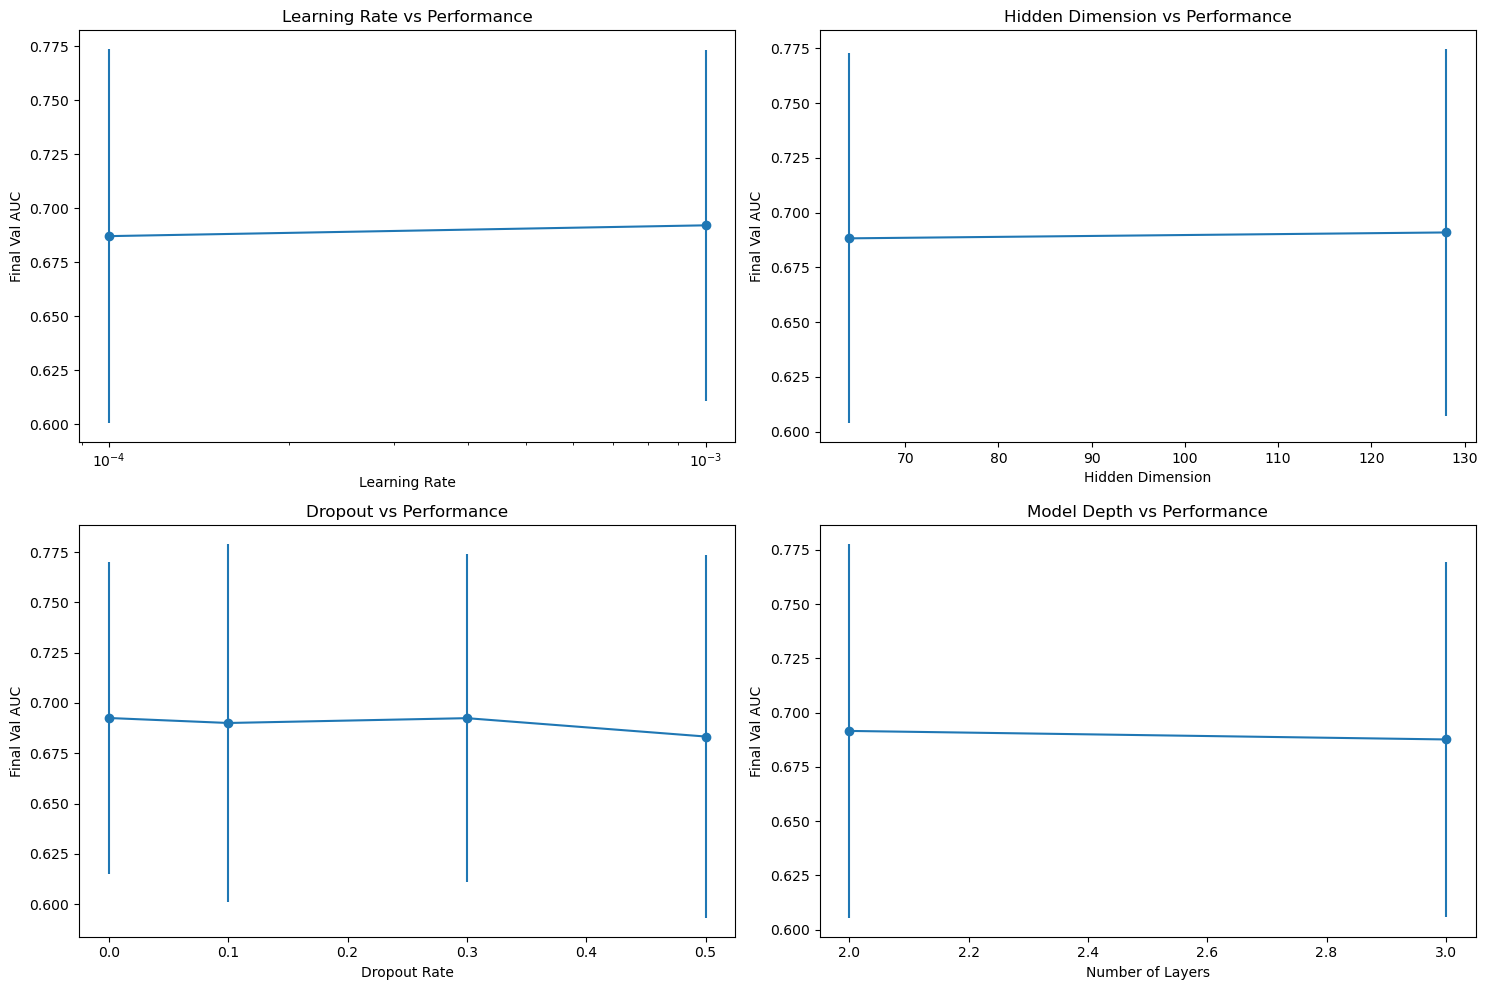


2. Creating model summary table...
Model Performance Summary (sorted by mean test AUC):
 hidden_dim  num_layers  learning_rate  test_auc_mean  test_auc_std  test_auc_count  test_precision_mean  test_recall_mean  test_f1_mean
         64           2         0.0010          0.766         0.094              16                0.234             0.767         0.348
        128           2         0.0001          0.756         0.102              16                0.226             0.770         0.343
        128           3         0.0001          0.755         0.102              16                0.228             0.734         0.344
         64           3         0.0010          0.747         0.111              16                0.221             0.727         0.329
        128           2         0.0010          0.742         0.120              16                0.199             0.650         0.297
        128           3         0.0010          0.737         0.117              16      

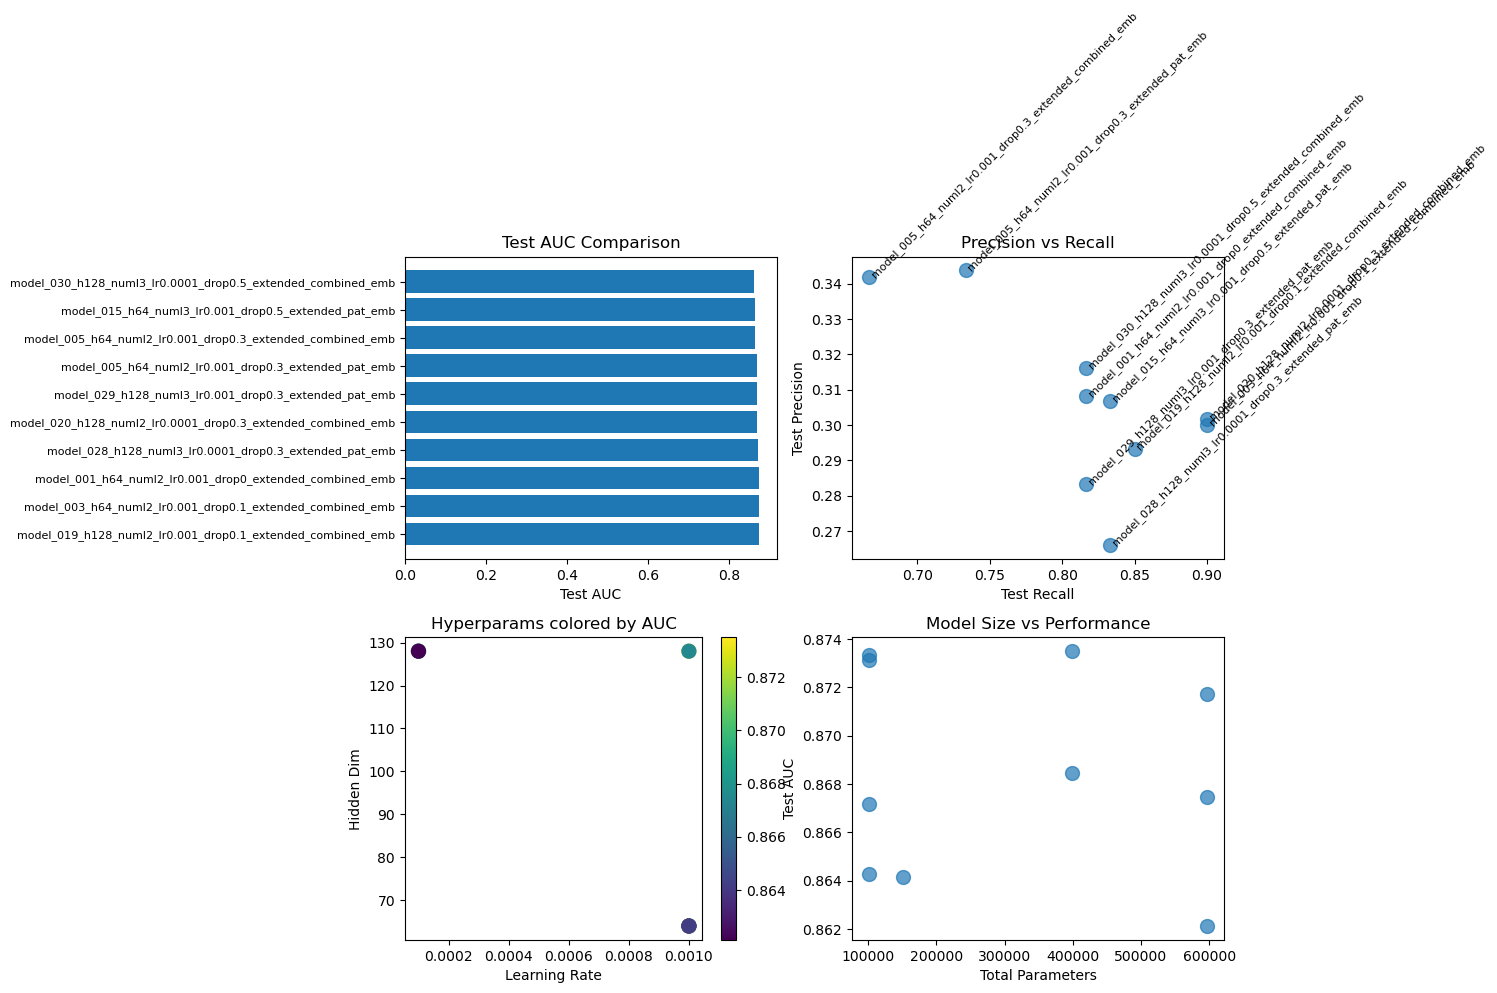


4. Creating hyperparameter heatmap...


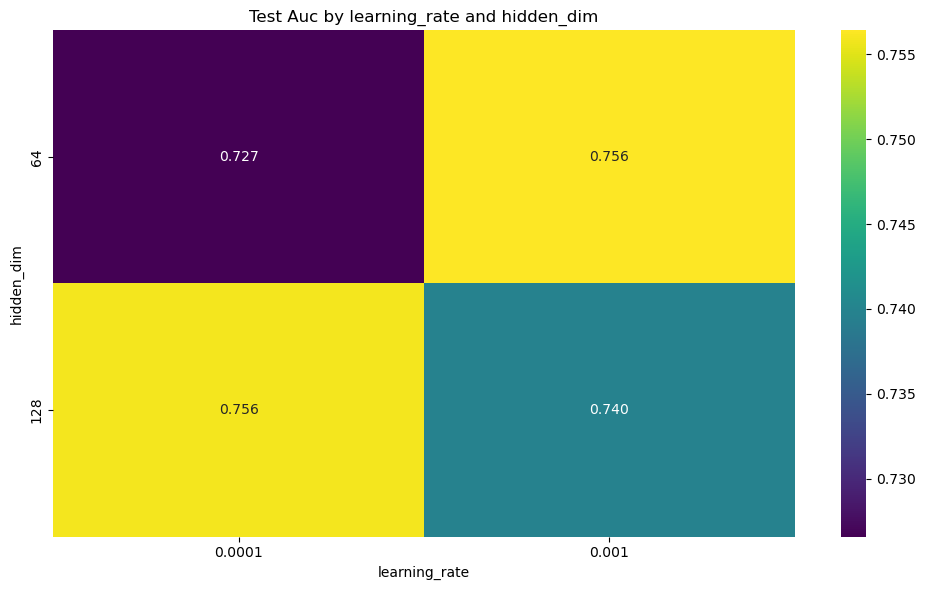


5. Plotting best vs worst models...


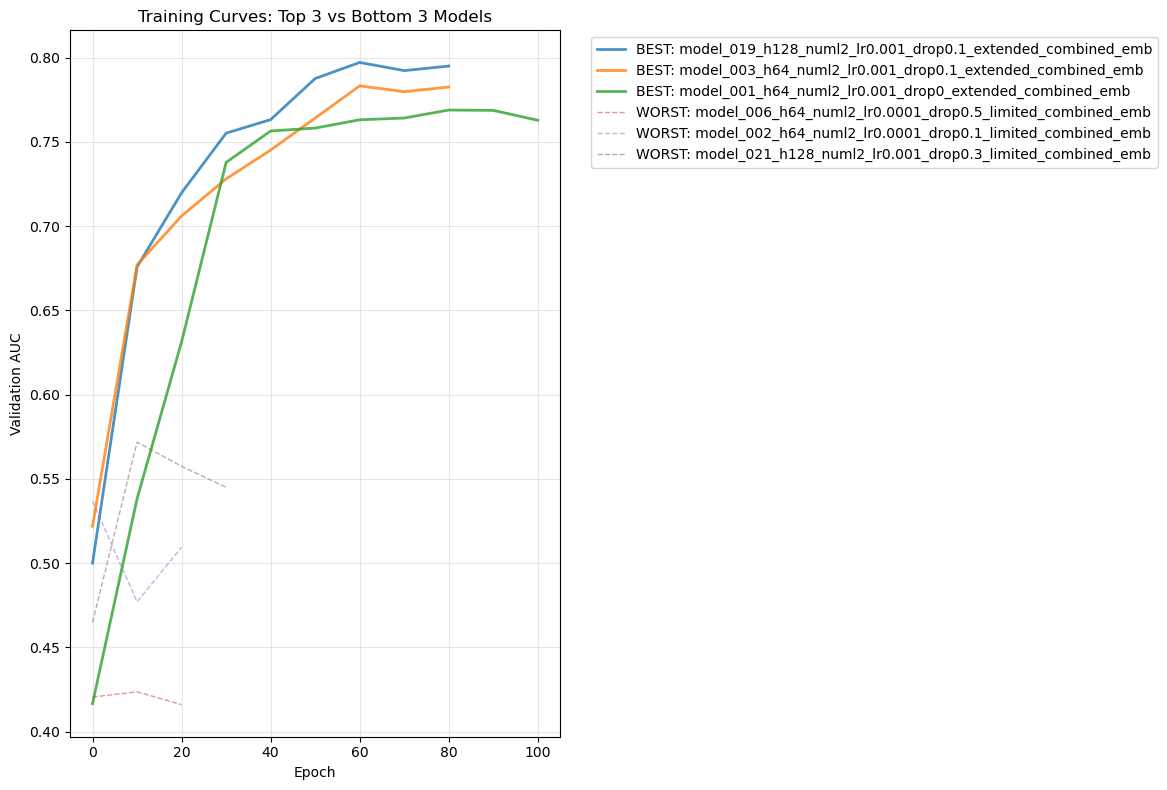

(                                            model_name  epoch   val_auc  \
 0    model_000_h64_numl2_lr0.0001_drop0_extended_co...    100  0.736117   
 1    model_000_h64_numl2_lr0.0001_drop0_extended_pa...     90  0.778251   
 2    model_000_h64_numl2_lr0.0001_drop0_limited_com...     80  0.634227   
 3    model_000_h64_numl2_lr0.0001_drop0_limited_pat...     90  0.588180   
 4    model_001_h64_numl2_lr0.001_drop0_extended_com...    100  0.762775   
 ..                                                 ...    ...       ...   
 123  model_030_h128_numl3_lr0.0001_drop0.5_limited_...     20  0.606322   
 124  model_031_h128_numl3_lr0.001_drop0.5_extended_...     50  0.776416   
 125  model_031_h128_numl3_lr0.001_drop0.5_extended_...     80  0.763329   
 126  model_031_h128_numl3_lr0.001_drop0.5_limited_c...     30  0.581014   
 127  model_031_h128_numl3_lr0.001_drop0.5_limited_p...    130  0.632288   
 
      hidden_dim  num_layers  learning_rate  drop_out  
 0            64           2  

In [9]:
run_all()

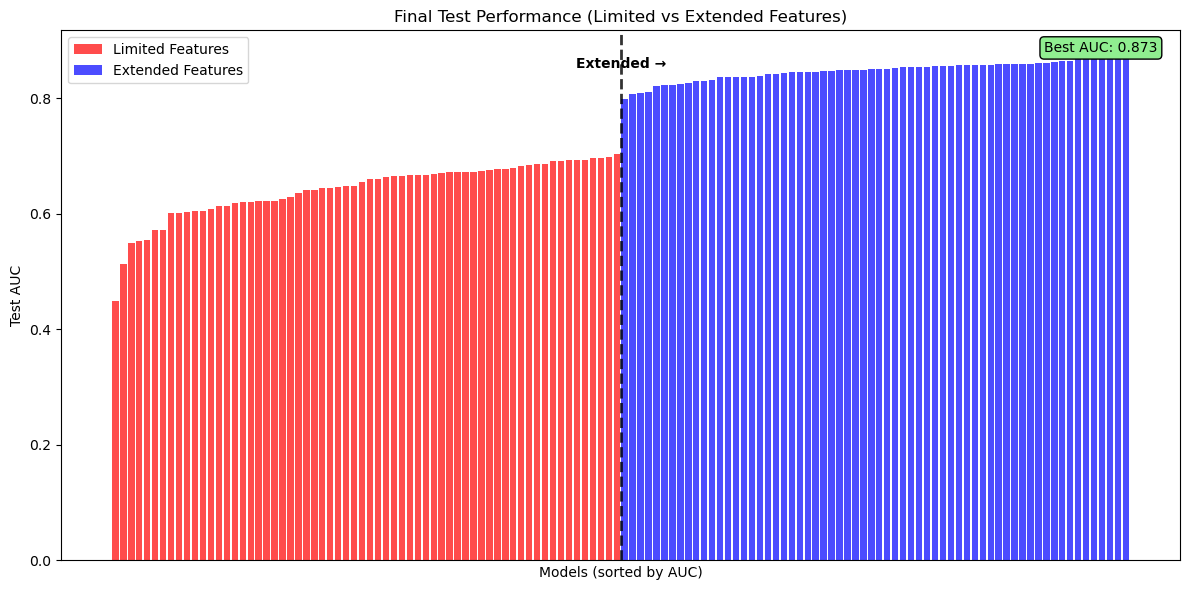

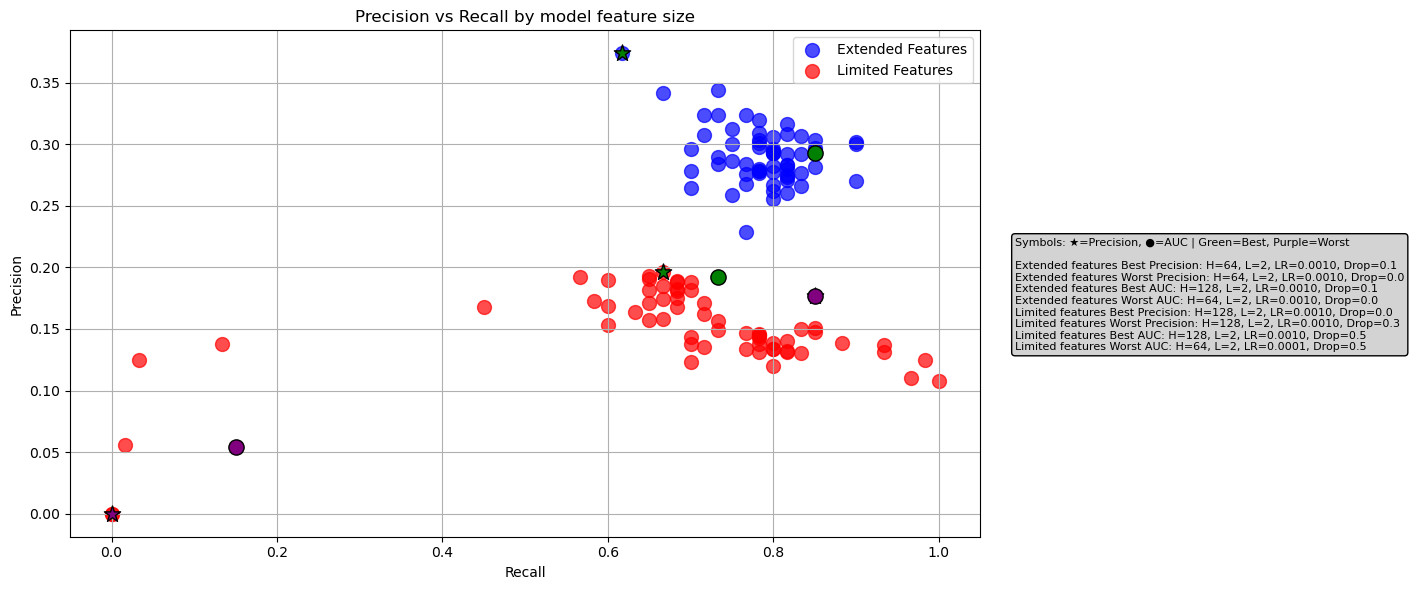

In [11]:
def plot_model_comparison(results_file="results/model_results_updated.csv", final_results_file="results/final_results_updated.csv"):
    """Plot comparison of different models"""
    
    # Load training curves
    df = pd.read_csv(results_file)
    
    # Final test results
    plt.figure(figsize=(12, 6))
    final_df = pd.read_csv(final_results_file)

    # Sort by test_auc
    final_df = final_df.sort_values('test_auc')

    # Create colour mapping
    colors = ['red' if 'limited' in desc.lower() else 'blue' if 'extended' in desc.lower() else 'gray' 
            for desc in final_df['model_description']]

    bars = plt.bar(range(len(final_df)), final_df['test_auc'], color=colors, alpha=0.7)

    # Find transition point from limited to extended
    extended_start = None
    for i, desc in enumerate(final_df['model_description']):
        if 'extended' in desc.lower():
            extended_start = i
            break

    # Add vertical line at transition
    if extended_start is not None:
        plt.axvline(x=extended_start-0.5, color='black', linestyle='--', linewidth=2, alpha=0.8)
        plt.text(extended_start-0.5, plt.ylim()[1]*0.95, 'Extended →', 
                ha='center', va='top', fontweight='bold')

    plt.ylabel('Test AUC')
    plt.title('Final Test Performance (Limited vs Extended Features)')
    plt.xlabel('Models (sorted by AUC)')

    # remove x-tick labels but keep bars
    plt.xticks([])

    # add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Limited Features'),
                    Patch(facecolor='blue', alpha=0.7, label='Extended Features')]
    plt.legend(handles=legend_elements, loc='upper left')

    # text showing best AUC
    best_auc = final_df['test_auc'].max()
    plt.text(0.98, 0.98, f'Best AUC: {best_auc:.3f}', 
            transform=plt.gca().transAxes, ha='right', va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.tight_layout()
    plt.show()
    
    # Precision vs Recall
    plt.figure(figsize=(10, 6))
    extended_mask = final_df['model_description'].str.contains('extended', case=False)
    limited_mask = final_df['model_description'].str.contains('limited', case=False)

    extended_data = final_df[extended_mask]
    plt.scatter(extended_data['test_recall'], extended_data['test_precision'], 
                s=100, alpha=0.7, color='blue', label='Extended Features')

    limited_data = final_df[limited_mask]
    plt.scatter(limited_data['test_recall'], limited_data['test_precision'], 
                s=100, alpha=0.7, color='red', label='Limited Features')

    other_mask = ~(extended_mask | limited_mask)
    if other_mask.any():
        other_data = final_df[other_mask]
        plt.scatter(other_data['test_recall'], other_data['test_precision'], 
                    s=100, alpha=0.7, color='gray', label='Other')

    def add_point_labels(data, color_prefix=""):
        if len(data) >= 2:
            best_prec = data.loc[data['test_precision'].idxmax()]
            worst_prec = data.loc[data['test_precision'].idxmin()]
            best_auc = data.loc[data['test_auc'].idxmax()]
            worst_auc = data.loc[data['test_auc'].idxmin()]

            #  best precision (green star)
            plt.scatter(best_prec['test_recall'], best_prec['test_precision'], 
                    marker='*', s=150, color='green', edgecolor='black', zorder=5)
            
            #  worst precision (purple star)
            plt.scatter(worst_prec['test_recall'], worst_prec['test_precision'], 
                    marker='*', s=150, color='purple', edgecolor='black', zorder=5)
            
            #  best AUC (green circle)
            plt.scatter(best_auc['test_recall'], best_auc['test_precision'], 
                    marker='o', s=120, color='green', edgecolor='black', zorder=5)
            
            #  worst AUC (purple circle)
            plt.scatter(worst_auc['test_recall'], worst_auc['test_precision'], 
                    marker='o', s=120, color='purple', edgecolor='black', zorder=5)
            
            # Return info for legend
            return {
                f'{color_prefix}Best Precision': f"H={int(best_prec['hidden_dim'])}, L={int(best_prec['num_layers'])}, LR={best_prec['learning_rate']:.4f}, Drop={best_prec.get('drop_out', 0):.1f}",
                f'{color_prefix}Worst Precision': f"H={int(worst_prec['hidden_dim'])}, L={int(worst_prec['num_layers'])}, LR={worst_prec['learning_rate']:.4f}, Drop={worst_prec.get('drop_out', 0):.1f}",
                f'{color_prefix}Best AUC': f"H={int(best_auc['hidden_dim'])}, L={int(best_auc['num_layers'])}, LR={best_auc['learning_rate']:.4f}, Drop={best_auc.get('drop_out', 0):.1f}",
                f'{color_prefix}Worst AUC': f"H={int(worst_auc['hidden_dim'])}, L={int(worst_auc['num_layers'])}, LR={worst_auc['learning_rate']:.4f}, Drop={worst_auc.get('drop_out', 0):.1f}"
            }


    # if len(extended_data) > 0:
    #     add_point_labels(extended_data, "Ext ")
    # if len(limited_data) > 0:
    #     add_point_labels(limited_data, "Lim ")
    legend_info = {}
    if len(extended_data) > 0:
        legend_info.update(add_point_labels(extended_data,"Extended features "))
    if len(limited_data) > 0:
        legend_info.update(add_point_labels(limited_data, "Limited features "))

    # Add symbol legend and model info
    symbol_legend = "Symbols: ★=Precision, ●=AUC | Green=Best, Purple=Worst"
    model_legend = '\n'.join([f"{k}: {v}" for k, v in legend_info.items()])
    full_legend = f"{symbol_legend}\n\n{model_legend}"

    plt.figtext(1.02, 0.5, full_legend, fontsize=8, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
           verticalalignment='center')
    
    # Adjust layout to make room for external legend
    plt.subplots_adjust(right=0.7) 
                
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall by model feature size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
#     plt.savefig('images/precision_v_recall_final',bbox_inches='tight')
    plt.show()

plot_model_comparison()
